In [27]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [9]:
import random
import math
import numpy as np
from random import shuffle

In [14]:
def readDataset():
    data = {'x_data': [], 'y_data': []}
    with open('test.csv') as file_handle:
        lines = file_handle.readlines()
        for line in lines:
            point = line.strip().split(',')
            label = point[-1]
            point = point[:-1]
            point = map(float, point)
            data['x_data'].append(point)
            data['y_data'].append(label)
    return data

In [15]:
def calculateMetrics(pred_clusters, true_labels_arr):
    true_labels = {}
    for index, true_label in enumerate(true_labels_arr):
        if true_label in true_labels:
            true_labels[true_label].append(index)
        else:
            true_labels[true_label] = [index]
    true_labels = true_labels.values()
    true_label_pairs = []
    for true_cluster in true_labels:
        true_cluster.sort()
        true_label_pairs += itertools.combinations(true_cluster, 2)
    
    pred_label_pairs = []
    for pred_cluster in pred_clusters:
        pred_cluster.sort()
        pred_label_pairs += itertools.combinations(pred_cluster, 2)
    print len(true_label_pairs), len(pred_label_pairs)
    true_label_pairs = set(true_label_pairs)
    pred_label_pairs = set(pred_label_pairs)
    print len(true_label_pairs), len(pred_label_pairs)
    
    precision = len(pred_label_pairs.intersection(true_label_pairs))/(1.0*len(pred_label_pairs))
    recall = len(pred_label_pairs.intersection(true_label_pairs))/(1.0*len(true_label_pairs))
    f1 = 2*precision*recall/(precision+recall)
    print "Precision: %0.2f, Recall: %0.2f"%(precision, recall)
    print "F1 score: %0.2f"%(f1)

In [16]:
def plotGoldStandards(i, j):
    points = np.array(data['x_data'])
    labels = data['y_data']
    mapping = {'Iris-setosa': 'red', 'Iris-versicolor': 'blue', 'Iris-virginica': 'green'}
    colors = [mapping[label] for label in labels]
    f, ax = plt.subplots(1)
    plt.scatter(points[:, i], points[:,j], c=colors)
    ax.legend()
    plt.show()

In [17]:
import sys
import heapq as hq
import numpy as np
import itertools
from random import shuffle

class Cluster(object):
    COUNTER = 0
    def __init__(self, points, p_ids, rep_count, alpha):
        Cluster.COUNTER += 1
        self.id = Cluster.COUNTER
        self.points = np.array(points) if type(points) == type([]) else points
        self.n_points, self.dimensions = self.points.shape
        self.p_ids = p_ids
        self.mean = None
        self.alpha = alpha
        self.rep_count = rep_count
        self.reps = self.assignReps()
        self.closest = None
        self.closestDist = sys.maxint

    def getMean(self):
        if self.mean is not None:
            return self.mean
        self.mean = self.points.sum(axis=0)/(self.n_points*1.0)
        return self.mean
    
    def assignReps(self):
        if self.n_points <= self.rep_count:
            return self.points[:,:]
        tmp_set = set()
        reps = []
        for i in range(self.rep_count):
            max_dist = 0
            for j in range(self.n_points):
                if i == 0:
                    min_dist = Cluster.p_distance(self.points[j], self.getMean())
                else:
                    min_dist = self.getClosestDist(self.points[j], reps)
                if min_dist >= max_dist:
                    max_dist = min_dist
                    max_point = j
            if max_point not in tmp_set:
                tmp_set.add(max_point)
                if reps is not None:
                    point = self.points[max_point]
                    reps.append(point + self.alpha * (self.getMean() - point))
                else:
                    point = self.points[max_point]
                    reps = [point + self.alpha * (self.getMean() - point)]
        reps = np.array(reps)
        return reps
            
                    
    def getClosestDist(self, point, points):
        points = np.array(points)
        return min(np.sqrt(np.sum((points - point)**2, axis=1)))
    
    def __str__(self):
        return "[ID:%d] PointCount=%d, ClosestDist=%0.2f with [ID:%d]"%(self.id, self.n_points, self.closestDist, self.closest.id if self.closest else -1)
    
    def __repr(self):
        return self.__str__()
    


    @classmethod
    def merge(cls, cluster1, cluster2):
        if cluster1.dimensions != cluster2.dimensions:
            raise ValueError('Error! The dimensions of the data-points does not match.')
        
        combined_points = np.concatenate((cluster1.points, cluster2.points))
        combined_p_ids = cluster1.p_ids + cluster2.p_ids
        new_cluster = Cluster(combined_points, combined_p_ids, cluster1.rep_count, cluster1.alpha)
        
        new_cluster.mean = (cluster1.getMean()*cluster1.n_points + cluster2.getMean()*cluster2.n_points)/(new_cluster.n_points*1.0)

        return new_cluster
    
    def pointToClusterDistance(self, point):
        min_dist = sys.maxint
        for rep_index in xrange(len(self.reps)):
            dist = Cluster.p_distance(self.reps[rep_index], point)
            min_dist = min(min_dist, dist)
        return min_dist
    
    @staticmethod
    def p_distance(point1, point2):
        return np.sqrt(np.sum((point1 - point2)**2))

    @staticmethod
    def c_distance(cluster1, cluster2):
        min_dist = sys.maxint
        for rep_1_index in xrange(len(cluster1.reps)):
            for rep_2_index in xrange(len(cluster2.reps)):
                dist = Cluster.p_distance(cluster1.reps[rep_1_index], cluster2.reps[rep_2_index])
                min_dist = min(min_dist, dist)
        return min_dist

In [18]:
class HeirarchicalClustering(object):
    def __init__(self, cluster_count, rep_count, alpha):
        self.cluster_count = cluster_count
        self.clusters = []
        self.rep_count = rep_count
        self.alpha = alpha

    def fit(self, points):
        for p_index, point in enumerate(points):
            self.clusters.append(Cluster([point], [p_index], self.rep_count, self.alpha))
        
        for index in xrange(len(self.clusters)):
            self.assignClosestCluster(self.clusters[index])
            
        while len(self.clusters) > self.cluster_count:
            u_index = self.getMergeCandidate()
            u_cluster = self.clusters.pop(u_index)
            v_cluster = u_cluster.closest
            
            self.removeCluster(v_cluster)
            
            new_cluster = Cluster.merge(u_cluster, v_cluster)
            
            self.rebuildClosestClusterLinks(new_cluster, u_cluster.id, v_cluster.id)
            
            self.clusters.append(new_cluster)
    
    def predict(self, points):
        points = np.array(points)
        predictions = {cluster.id:[] for cluster in self.clusters}
        for i in range(len(points)):
            label = self.predict_point(points[i])
            predictions[label].append(i)
        return predictions.values()

    def predict_point(self, point):
        point = np.array(point)
        min_dist = sys.maxint
        label = None
        for i in range(len(self.clusters)):
            dist = self.clusters[i].pointToClusterDistance(point)
            if dist < min_dist:
                min_dist = dist
                label = self.clusters[i].id
        return label
    
    def getMergeCandidate(self):
        min_dist = sys.maxint
        cluster_index = 0
        for i in range(len(self.clusters)):
            dist = self.clusters[i].closestDist
            if dist < min_dist:
                min_dist = dist
                cluster_index = i
        return cluster_index
            
    def assignClosestCluster(self, cluster):
        min_dist = sys.maxint
        closest = None
        for i in range(len(self.clusters)):
            if cluster.id == self.clusters[i].id: continue
            
            dist = Cluster.c_distance(cluster, self.clusters[i])
            if dist < min_dist:
                min_dist = dist
                closest = self.clusters[i]
        cluster.closest = closest
        cluster.closestDist = min_dist

    def rebuildClosestClusterLinks(self, new_cluster, cid_1, cid_2):
        min_dist = sys.maxint
        for i in range(len(self.clusters)):
            new_dist = Cluster.c_distance(new_cluster, self.clusters[i])
            if new_cluster.closestDist > new_dist:
                new_cluster.closestDist = new_dist
                new_cluster.closest = self.clusters[i]

            if self.clusters[i].closest.id in (cid_1, cid_2):
                if self.clusters[i].closestDist < new_dist:
                    self.assignClosestCluster(self.clusters[i])
                else:
                    self.clusters[i].closestDist = new_dist
                    self.clusters[i].closest = new_cluster
            else:
                if self.clusters[i].closestDist > new_dist:
                    self.clusters[i].closestDist = new_dist
                    self.clusters[i].closest = new_cluster
    
    def removeCluster(self, cluster):
        for i in range(len(self.clusters)):
            if self.clusters[i].id == cluster.id:
                self.clusters[i] = self.clusters[-1]
                self.clusters.pop()
                return
        print "Cluster not found : ", cluster.id, cluster.p_ids

In [19]:
def gridSearch():
    rep_counts = list(range(1, 6))
    alphas = np.arange(0.1, 1, 0.1)
    for rep_count in rep_counts:
        for alpha in alphas:
            hc = HeirarchicalClustering(3, rep_count, alpha)
            hc.fit(data['x_data'])
            plotPoints(hc.clusters)
            print 'RepCount: %d, Alpha: %f'%(rep_count, alpha)
            calculateMetrics(hc.clusters, data['y_data'])
            

In [20]:
def plotPoints(clusters):
    f, ax = plt.subplots(1)
    for i, cluster in enumerate(clusters):
        points = np.array(cluster.points)
        plt.scatter(points[:, 0], points[:, 1], label=i)
    ax.legend()
    plt.show()

In [21]:
data = readDataset()
sample = data['x_data']
shuffle(sample)
sample = sample[:200]
with open('sample.txt', 'w') as f:
    f.write('\n'.join([','.join(map(str, nums) + ['abc']) for nums in sample]))

In [22]:
sample = data['x_data']
shuffle(sample)
sample = sample[:200]

In [23]:
with open('sample.txt', 'w') as f:
    f.write('\n'.join([','.join(map(str, nums) + ['abc']) for nums in sample]))

In [ ]:
cluster_count = 3
rep_count = 2
alpha = 0.8
hc = HeirarchicalClustering(5, 6, 0.5)
hc.fit(sample)
predictions = hc.predict(data['x_data'])

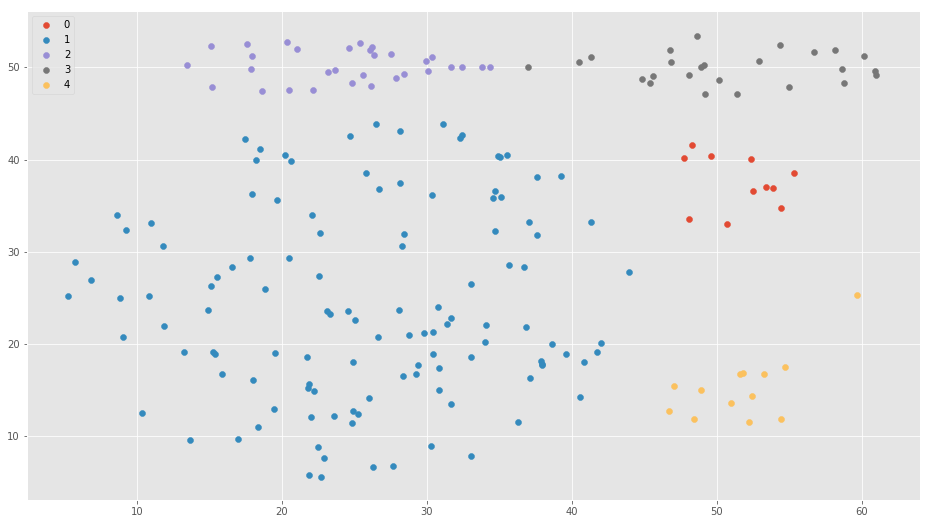

In [28]:
plotPoints(hc.clusters)
# calculateMetrics(predictions, data['y_data'])

In [25]:
# gridSearch()

In [ ]:
# plotGoldStandards(0, 2)

In [29]:
def plotPoints2(points, colors):
    plt.scatter(points[:, 0], points[:,1], c=colors, s=1)
    plt.xlim(0, 70)
    plt.ylim(0, 70)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [30]:
def circlePoint(circle_x = 12, circle_y = 12, circle_r = 10):
    alpha = 2 * math.pi * random.random()
    r = circle_r * math.sqrt(random.random())
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y
    return [x, y]

In [31]:
def elipsePoint(pos_x=5, pos_y=7, h=8, w=2):
    x, y = circlePoint(circle_x = 0, circle_y = 0, circle_r = 3)
    return [x*w + pos_x, y*h+pos_y]
    

In [32]:
points = 12000
circle = np.array([circlePoint(circle_x = 25, circle_y = 25, circle_r = 20) for _ in range(points)])
circle_colors = ['red' for _ in range(points)]

In [33]:
points = 2000
elipse_b = np.array([elipsePoint(pos_x=20, pos_y=55, h=1, w=4) for _ in range(points)])
elipse_b_colors = ['blue' for _ in range(points)]

In [34]:
points = 2000
elipse_g = np.array([elipsePoint(pos_x=50, pos_y=55, h=1, w=4) for _ in range(points)])
elipse_g_colors = ['green' for _ in range(points)]

In [35]:
points = 1000
circle_s1 = np.array([circlePoint(circle_x=56, circle_y = 37, circle_r = 5) for _ in range(points)])
circle_colors_s1 = ['black' for _ in range(points)]

In [36]:
points = 1000
circle_s2 = np.array([circlePoint(circle_x = 56, circle_y = 15, circle_r = 5) for _ in range(points)])
circle_colors_s2 = ['purple' for _ in range(points)]

In [47]:
points = 100
line = np.array([[(random.random()*10)%7 + 31, 55] for _ in range(points)])
line_b_colors = ['blue' for _ in range(points)]

In [48]:
points = 500
ran_colors = ['red', 'blue', 'green', 'black', 'purple']
outliers = np.array([[random.random()*65, random.random()*60] for _ in range(points)])
outliers_red_colors = [ran_colors[i % len(ran_colors)] for i in range(points)]

In [49]:
combined = np.concatenate([circle, elipse_b, elipse_g, circle_s1, circle_s2, line, outliers])
combined_color = circle_colors + elipse_b_colors + elipse_g_colors + circle_colors_s1 + circle_colors_s2 + line_b_colors + outliers_red_colors

output = ''
for i in range(len(combined)):
    output += '%0.2f,%0.2f,0,0,%s\n'%(combined[i][0], combined[i][1], combined_color[i])
with open('test.csv', 'w') as f:
    f.write(output)

data = readDataset()
sample = data['x_data']
shuffle(sample)
sample = sample[:200]
with open('sample.txt', 'w') as f:
    f.write('\n'.join([','.join(map(str, nums) + ['abc']) for nums in sample]))

In [50]:
points = np.concatenate([circle, elipse_b, elipse_g, circle_s1, circle_s2, line, outliers])
colors = circle_colors + elipse_b_colors + elipse_g_colors + circle_colors_s1 + circle_colors_s2 + line_b_colors + outliers_red_colors

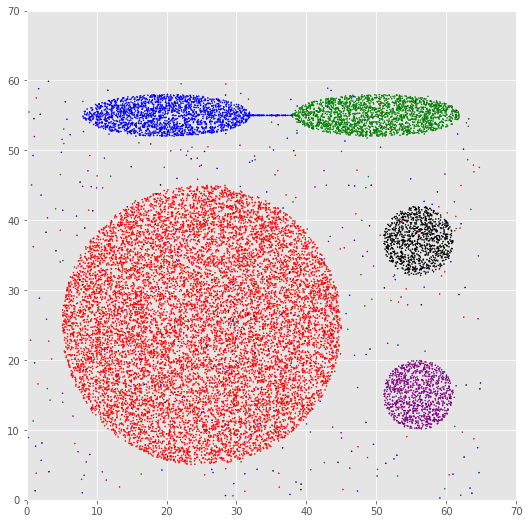

In [51]:
plotPoints2(points, colors)

In [260]:
random.random()

0.026088340794432896

In [261]:
random.random()

0.5725050151108498